Dataset Name and Link to Dataset:

My dataset is stored locally on my computer. It is part of a large, private Git repository that the Robotics and Dynamics Lab (RaD Lab) uses, so I cannot move it to a Google CoLab notebook. I will be using it locally in a ipynb on my computer, however. In our lab, we call this dataset "RaD Models". 

Type of Data

This "dataset" is basically a collection of mathematical equations for dynamic models (ie inverted pendulums, mass spring dampers, triple inverted pendulums, soft robots, cart pendulums, etc). You give a model the current state of the system (i.e. the angle of a pendulum in the case of inverted pendulums), and an input to the system (like a motor torque) and the model will output the next state of the system. It is somewhat similar to RL in that these models would be the "world" that you "roll out" to get a reward. 

Pytorch Interface to Dataset

In [1]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

sys.path.append('/home/haleysanders/haley_ws/src/rad_models/src/rad_models/')
from MassSpringDamper import MassSpringDamper
from tqdm import tqdm


In [20]:
class DynamicSystemDataSet():
    
    def __init__(self, system):
        
        # dynamic model of system we care about (ie mass spring damper, inverted pendulum, etc.)
        self.system = system
        self.system.uMin = -self.system.uMax
        
        # timestep
        self.dt = .01
        
    def forward_simulate(self, state, input, steps, visualize=False):
        
        # convert state and inputs from torch tensors to numpy arrays
        state = self.convert_to_numpy_array(state, self.system.numStates)
        input = self.convert_to_numpy_array(input, self.system.numInputs)
        
        for i in range(steps):    
            # get next state by forward simulating
            state = self.system.forward_simulate_dt(state, input, self.dt)
            
            # visualize
            if visualize == True:
                if i%10==0:
                    self.system.visualize(state, input)
        
        # convert next state back to torch tensor
        nextState = self.convert_to_torch_tensor(state)
        
        return nextState.cuda(non_blocking=True)
    
    def convert_to_numpy_array(self, tensor, arrayDim):
        
        convertedArray = np.zeros([arrayDim, 1])
        convertedArray[:, 0] = np.array(tensor)    
        
        return np.array(convertedArray)
    
    def convert_to_torch_tensor(self, array):
        
        array = array.flatten()        
        tensor = torch.Tensor(array)
        
        return tensor

Simulation of Dataset (with Mass Spring Damper):

Right now, the "visualization" of the dataset is a set of stills of the dynamical system moving in space. If this were not a ipynb, it would show up as a movie instead of a series of pictures.

In [21]:
class LinearNetwork(nn.Module):
  def __init__(self, numVars):
    super(LinearNetwork, self).__init__()

    self.net = nn.Sequential(nn.Linear(numVars, 100), 
                             nn.ReLU(),
                             nn.Linear(100, numVars - 1))
  
  def forward(self, x):
    return self.net(x)

In [32]:
def calculate_loss(yHat, yTruth):
    
    error = yHat - yTruth
    costWeights = torch.Tensor([[1, 0], [0, 1]]).cuda()
    
    loss = 0
    for h in range(error.shape[0]):
        loss = loss + torch.matmul(torch.matmul(error[h, :], costWeights), torch.unsqueeze(error[h, :], 1))
    
    return loss

In [33]:
#"Dataset" Variables
system = MassSpringDamper()
dataset = DynamicSystemDataSet(system)

# Model and loss and optimizer functions
numVars = dataset.system.numStates + dataset.system.numInputs
model = LinearNetwork(numVars).cuda()
optimizer = optim.SGD(model.parameters(), lr=1e-4)
objective = torch.nn.CrossEntropyLoss()

In [46]:
# Instatiate training and validation losses
train_losses = []
validation_losses = []
batch_size = 42

num_epochs = 1000000
loop = tqdm(total=num_epochs, position=0)

# Training and Validation Loops
for epoch in range(num_epochs):

    # zero out gradients
    optimizer.zero_grad()
    
    # generate random state and input
    state = (10--10)*torch.rand((batch_size, 2)) - 10
    input = (10--10)*torch.rand((batch_size, 1)) - 10
    
    # get true next state value
    nextStateTruth = torch.zeros((batch_size, 2)).cuda(non_blocking=True)
    for j in range(state.shape[0]):
        nextStateTruth[j, :] = dataset.forward_simulate(state[j, :], input[j], steps = 1)
        
    # get next state value from network
    stateAndInput = torch.hstack((state, input)).cuda(non_blocking=True)
    nextStateHat = model.forward(stateAndInput)
        
    # calculate loss
    loss = calculate_loss(nextStateHat, nextStateTruth)
    
    if epoch % 2 == 0:
        train_losses.append(loss.item())
    
    loop.set_description('epoch:{} loss:{:.4f}'.format(epoch, loss.item()))  
    loop.update(True)      
    
    loss.backward()
    optimizer.step()
    
loop.close()


epoch:1698 loss:0.0692:   0%|          | 1698/1000000 [00:32<4:44:32, 58.47it/s]

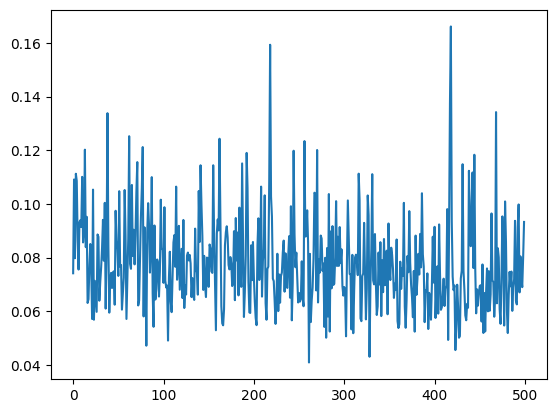

In [44]:
fig = plt.figure()
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.show()

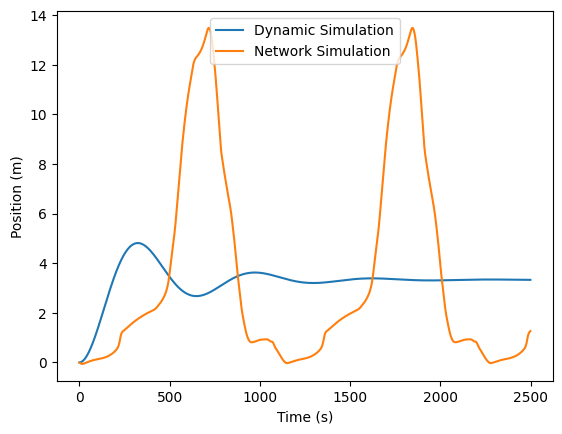

In [45]:
stateTruth = np.array([[0.0], [0.0]])
input = 10.0
stateAndInput = torch.Tensor([0.0, 0.0, input]).cuda()

steps = 2500
stateTruthHist = np.zeros((2, steps))
stateHatHist = torch.zeros((2, steps))

for i in range(steps):
    
    stateTruth = dataset.system.forward_simulate_dt(stateTruth, input, dataset.dt)
    stateTruthHist[:, i] = stateTruth.flatten()

    stateHat = model.forward(stateAndInput)
    stateAndInput = torch.Tensor([stateHat[0], stateHat[1], input]).cuda()
    stateHatHist[:, i] = stateHat.flatten()

plt.plot(stateTruthHist[0, :])
plt.plot(stateHatHist.detach().numpy()[0, :])
plt.legend(['Dynamic Simulation', 'Network Simulation'])
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()

In [ ]:
# Get number of parameters in network
sum = 0
for p in model.parameters():
  params  = 1
  for s in p.size():
    params = params * s
  sum = sum + params
print('Number of Parameters In Network: ', sum)

In [ ]:
# Instatiate training and validation losses
train_losses = []
validation_losses = []

num_epochs = 500000
loop = tqdm(total=num_epochs, position=0)

# Training and Validation Loops
for epoch in range(num_epochs):

    # zero out gradients
    optimizer.zero_grad()
    
    # generate random state and input
    state = torch.Tensor([random.uniform(-10, 10), random.uniform(-10, 10)])
    input = torch.Tensor([random.uniform(-10, 10)])
    
    # get true next state value
    nextStateTruth = dataset.forward_simulate(state, input, steps = 1)
        
    # get next state value from network
    stateAndInput = torch.cat((state, input)).cuda(non_blocking=True)
    nextStateHat = model.forward(stateAndInput)
        
    # calculate loss
    loss = calculate_loss(nextStateHat, nextStateTruth)
    
    if epoch % 2 == 0:
        train_losses.append(loss.item())
    
    loop.set_description('epoch:{} loss:{:.4f}'.format(epoch, loss.item()))  
    loop.update(True)      
    
    loss.backward()
    optimizer.step()
    
loop.close()
